In [ ]:
# Installing necessary libraries
!pip install numpy pandas geopandas scikit-learn matplotlib pykrige

# Step 2: Import Libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from pykrige.ok import OrdinaryKriging  # For Kriging interpolation

In [ ]:
# Loading CSV data for weather station measurements and metadata
weather_data = pd.read_csv('weather_station_data_202406202154.csv')
station_data = pd.read_csv('weather_stations_202406211148.csv')

In [ ]:
# Loading geographic shapefiles for lakes and rivers
aosta_lakes = gpd.read_file('idrografia_laghi.shp')
aosta_rivers = gpd.read_file('idrografia_lineare.shp')

In [ ]:
# Displaying data to confirm it loaded correctly
print(weather_data.head())
print(station_data.head())
print(aosta_lakes.head())
print(aosta_rivers.head())

  station_id  temperature                timestamp
0        NaN         16.0  2024-05-04 18:41:22.000
1        NaN         16.1  2024-05-05 19:26:04.000
2        NaN         12.2  2024-05-06 06:35:18.000
3        NaN         11.0  2024-05-07 09:21:12.000
4        NaN         10.9  2024-05-07 10:06:30.000
                 id                                     name  altitude  \
0     castelceriolo         Alessandria, fraz. Castelceriolo       100   
1   orsieres-prayon                    Orsières, Prayon (CH)      1509   
2           alpette                             Alpette (TO)       980   
3  alluvioni-cambio  Alluvioni Piovera, fraz. Baracconi (AL)        79   
4   alice-bel-colle                     Alice Bel Colle (AL)       418   

   latitude  longitude  
0   8.70080   44.90400  
1   7.10440   45.94800  
2   7.58150   45.40710  
3   8.77137   44.98922  
4   8.45050   44.72560  
  codcom cod_lago                     nome    tiplago immlago  quota  \
0    007     None  LACS DES

In [ ]:
# Renaming 'id' to 'station_id' in station_data for merging
station_data.rename(columns={'id': 'station_id'}, inplace=True)

In [ ]:
# Merging weather data with station metadata using station_id
merged_data = pd.merge(weather_data, station_data, on='station_id', how='right')

In [ ]:
# Converting merged data to GeoDataFrame for spatial analysis
station_gdf = gpd.GeoDataFrame(
    merged_data,
    geometry=gpd.points_from_xy(merged_data.longitude, merged_data.latitude),
    crs="EPSG:4326"
)


In [ ]:
# Checking the merged data
print(station_gdf.head())

      station_id  temperature                timestamp  \
0  castelceriolo         17.2  2024-05-01 00:00:05.174   
1  castelceriolo         17.1  2024-05-01 00:05:04.485   
2  castelceriolo         16.9  2024-05-01 00:10:04.772   
3  castelceriolo         16.6  2024-05-01 00:15:05.279   
4  castelceriolo         16.4  2024-05-01 00:20:04.545   

                               name  altitude  latitude  longitude  \
0  Alessandria, fraz. Castelceriolo       100    8.7008     44.904   
1  Alessandria, fraz. Castelceriolo       100    8.7008     44.904   
2  Alessandria, fraz. Castelceriolo       100    8.7008     44.904   
3  Alessandria, fraz. Castelceriolo       100    8.7008     44.904   
4  Alessandria, fraz. Castelceriolo       100    8.7008     44.904   

                geometry  
0  POINT (44.904 8.7008)  
1  POINT (44.904 8.7008)  
2  POINT (44.904 8.7008)  
3  POINT (44.904 8.7008)  
4  POINT (44.904 8.7008)  


In [ ]:
# Reprojecting GeoDataFrames to UTM for distance calculations
station_gdf = station_gdf.to_crs("EPSG:32632")
aosta_lakes = aosta_lakes.to_crs("EPSG:32632")
aosta_rivers = aosta_rivers.to_crs("EPSG:32632")

In [ ]:
if 'index_right' in station_gdf.columns:
    station_gdf.drop(columns=['index_right'], inplace=True)
if 'index_right' in aosta_lakes.columns:
    aosta_lakes.drop(columns=['index_right'], inplace=True)

In [ ]:
# Finding nearest lake for each station (using spatial join)
nearest_lakes = gpd.sjoin_nearest(station_gdf, aosta_lakes, how='left', distance_col='distance_to_lake')

In [ ]:
if 'index_right' in nearest_lakes.columns:
    nearest_lakes.drop(columns=['index_right'], inplace=True)

In [ ]:
# Finding nearest river for each station (using spatial join)
nearest_rivers = gpd.sjoin_nearest(nearest_lakes, aosta_rivers, how='left', distance_col='distance_to_river')

In [ ]:
station_gdf = nearest_rivers


In [ ]:
print(station_gdf.columns)

Index(['station_id', 'temperature', 'timestamp', 'name', 'altitude',
       'latitude', 'longitude', 'geometry', 'codcom', 'cod_lago', 'nome_left',
       'tiplago', 'immlago', 'quota', 'orilago', 'st_area_sh',
       'st_length__left', 'distance_to_lake', 'index_right', 'ordine', 'tipol',
       'dir_flusso', 'cod_sibapo', 'llpp', 'codice', 'cod_siba_1', 'z_ini',
       'z_fin', 'nome_right', 'num_archi', 'lung_tot', 'tratto', 'pendenz_m',
       'denbacpri', 'codbacpri', 'denbacsec', 'codbacsec', 'principale',
       'lung_geom', 'st_length__right', 'distance_to_river'],
      dtype='object')


In [ ]:
# Converting timestamp to datetime format if not already done
station_gdf['timestamp'] = pd.to_datetime(station_gdf['timestamp'])

In [ ]:
# Adding temporal features
station_gdf['hour'] = station_gdf['timestamp'].dt.hour
station_gdf['day_of_week'] = station_gdf['timestamp'].dt.dayofweek
station_gdf['day_of_year'] = station_gdf['timestamp'].dt.dayofyear
station_gdf['month'] = station_gdf['timestamp'].dt.month

In [ ]:
print(station_gdf.head())

      station_id  temperature               timestamp  \
0  castelceriolo         17.2 2024-05-01 00:00:05.174   
1  castelceriolo         17.1 2024-05-01 00:05:04.485   
2  castelceriolo         16.9 2024-05-01 00:10:04.772   
3  castelceriolo         16.6 2024-05-01 00:15:05.279   
4  castelceriolo         16.4 2024-05-01 00:20:04.545   

                               name  altitude  latitude  longitude  \
0  Alessandria, fraz. Castelceriolo       100    8.7008     44.904   
1  Alessandria, fraz. Castelceriolo       100    8.7008     44.904   
2  Alessandria, fraz. Castelceriolo       100    8.7008     44.904   
3  Alessandria, fraz. Castelceriolo       100    8.7008     44.904   
4  Alessandria, fraz. Castelceriolo       100    8.7008     44.904   

                          geometry codcom cod_lago  ...       denbacsec  \
0  POINT (4722996.733 1184669.834)    042     None  ...  Torrent Pacola   
1  POINT (4722996.733 1184669.834)    042     None  ...  Torrent Pacola   
2  POINT (4

In [ ]:
# Dropping rows with NaN values in the target variable
station_gdf = station_gdf.dropna(subset=['temperature'])

In [20]:
station_gdf['hour'] = station_gdf['timestamp'].dt.hour


c:\Users\niran\miniconda3\envs\era5_project\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
#Prprocessing Step
import pandas as pd


y = station_gdf['temperature']

X = station_gdf.drop(columns=['temperature', 'geometry', 'timestamp', 'station_id', 'name'])

numeric_columns = X.select_dtypes(include=['number']).columns
non_numeric_columns = X.select_dtypes(exclude=['number']).columns

X[numeric_columns] = X[numeric_columns].apply(lambda col: col.fillna(col.median()))

X[non_numeric_columns] = X[non_numeric_columns].fillna('missing')

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.head())


         altitude  latitude  longitude codcom cod_lago nome_left  tiplago  \
840560        920   7.23600   44.84200    042  missing   DE LACE  missing   
787951       3360   7.01940   45.63440    042  missing   DE LACE  missing   
174197        340   8.10090   45.54080    042  missing   DE LACE  missing   
1968744       545   7.22000   44.81980    042  missing   DE LACE  missing   
2009362       146   8.20097   44.90047    042  missing   DE LACE  missing   

         immlago  quota  orilago  ...       denbacsec  codbacsec  principale  \
840560   missing   1929  missing  ...  Torrent Pacola      13.22           0   
787951   missing   1929  missing  ...  Torrent Pacola      13.22           0   
174197   missing   1929  missing  ...  Torrent Pacola      13.22           0   
1968744  missing   1929  missing  ...  Torrent Pacola      13.22           0   
2009362  missing   1929  missing  ...  Torrent Pacola      13.22           0   

          lung_geom  st_length__right  distance_to_river

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),       
        ('cat', OneHotEncoder(handle_unknown='ignore'), non_numeric_columns)  
    ]
)


In [ ]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [24]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

ridge_model = Ridge(alpha=1.0)
ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', ridge_model)])
ridge_pipeline.fit(X_train, y_train)
ridge_predictions = ridge_pipeline.predict(X_test)


In [25]:
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=0.1)
lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', lasso_model)])
lasso_pipeline.fit(X_train, y_train)
lasso_predictions = lasso_pipeline.predict(X_test)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



y_pred_ridge = ridge_pipeline.predict(X_test)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Ridge Model Evaluation Metrics:\n MSE: {mse_ridge}\n MAE: {mae_ridge}\n R² Score: {r2_ridge}")

y_pred_lasso = lasso_pipeline.predict(X_test)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Lasso Model Evaluation Metrics:\n MSE: {mse_lasso}\n MAE: {mae_lasso}\n R² Score: {r2_lasso}")


Ridge Model Evaluation Metrics:
 MSE: 13.470876518647854
 MAE: 2.8150440543249835
 R² Score: 0.5571789039815456
Lasso Model Evaluation Metrics:
 MSE: 13.521896322443967
 MAE: 2.822257915024016
 R² Score: 0.5555017565884739


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

ridge_param_grid = {
    'ridge__alpha': [0.1, 1, 10, 100]  
}

ridge_grid_search = GridSearchCV(estimator=ridge_pipeline,
                                 param_grid=ridge_param_grid,
                                 cv=5,  
                                 scoring='neg_mean_squared_error', 
                                 n_jobs=-1,  
                                 verbose=1)


ridge_grid_search.fit(X_train, y_train)

print("Best Ridge Hyperparameters:", ridge_grid_search.best_params_)

best_ridge_model = ridge_grid_search.best_estimator_

y_pred_ridge_best = best_ridge_model.predict(X_test)

mse_ridge_best = mean_squared_error(y_test, y_pred_ridge_best)
mae_ridge_best = mean_absolute_error(y_test, y_pred_ridge_best)
r2_ridge_best = r2_score(y_test, y_pred_ridge_best)

print(f"Best Ridge Model Evaluation Metrics:\n MSE: {mse_ridge_best}\n MAE: {mae_ridge_best}\n R² Score: {r2_ridge_best}")


In [ ]:
from sklearn.linear_model import Lasso

lasso_param_grid = {
    'lasso__alpha': [0.1, 0.5, 1, 10, 100]  
}

lasso_grid_search = GridSearchCV(estimator=lasso_pipeline,
                                 param_grid=lasso_param_grid,
                                 cv=5,  
                                 scoring='neg_mean_squared_error',  
                                 n_jobs=-1,  
                                 verbose=1)

lasso_grid_search.fit(X_train, y_train)

print("Best Lasso Hyperparameters:", lasso_grid_search.best_params_)

best_lasso_model = lasso_grid_search.best_estimator_

y_pred_lasso_best = best_lasso_model.predict(X_test)

mse_lasso_best = mean_squared_error(y_test, y_pred_lasso_best)
mae_lasso_best = mean_absolute_error(y_test, y_pred_lasso_best)
r2_lasso_best = r2_score(y_test, y_pred_lasso_best)

print(f"Best Lasso Model Evaluation Metrics:\n MSE: {mse_lasso_best}\n MAE: {mae_lasso_best}\n R² Score: {r2_lasso_best}")


In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

sample_fraction = 0.1  
X_train_sampled, _, y_train_sampled, _ = train_test_split(X_train, y_train, train_size=sample_fraction, random_state=42)

numeric_features = X_train_sampled.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X_train_sampled.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

svr_model = SVR(kernel='linear', C=1.0)  
svr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', svr_model)])

svr_pipeline.fit(X_train_sampled, y_train_sampled)

y_pred_svr = svr_pipeline.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse_svr = mean_squared_error(y_test, y_pred_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"SVR Model Evaluation Metrics on Sampled Data:\n MSE: {mse_svr}\n MAE: {mae_svr}\n R² Score: {r2_svr}")


SVR Model Evaluation Metrics on Sampled Data:
 MSE: 15.615133150325931
 MAE: 3.0103340021017426
 R² Score: 0.4866918743907024


In [29]:
from lightgbm import LGBMRegressor


In [ ]:
lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)  

lgbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('model', lgbm_model)])

lgbm_pipeline.fit(X_train_sampled, y_train_sampled)

y_pred_lgbm = lgbm_pipeline.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f"LightGBM Model Evaluation Metrics on Sampled Data:\n MSE: {mse_lgbm}\n MAE: {mae_lgbm}\n R² Score: {r2_lgbm}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1287
[LightGBM] [Info] Number of data points in the train set: 195221, number of used features: 7
[LightGBM] [Info] Start training from score 13.452340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)  # Set lower number of trees
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost - MSE: {mse_xgb}, MAE: {mae_xgb}, R2 Score: {r2_xgb}")


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
import matplotlib.pyplot as plt
from spreg import ML_Error, ML_Lag  # Spatial econometrics models
from libpysal.weights import Queen  # For spatial weights matrix
# Spatial econometrics models
from spreg import ML_Error, ML_Lag
from libpysal.weights import KNN

In [ ]:


rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - MSE: {mse_rf}, MAE: {mae_rf}, R2 Score: {r2_rf}")


svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train)
y_pred_svr = svr_model.predict(X_test_scaled)

mse_svr = mean_squared_error(y_test, y_pred_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
print(f"SVR - MSE: {mse_svr}, MAE: {mae_svr}, R2 Score: {r2_svr}")

base_learners = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('svr', SVR(kernel='rbf', C=1.0, epsilon=0.1))
]
stacking_model = StackingRegressor(estimators=base_learners, final_estimator=GradientBoostingRegressor())
stacking_model.fit(X_train_scaled, y_train)
y_pred_stack = stacking_model.predict(X_test_scaled)

mse_stack = mean_squared_error(y_test, y_pred_stack)
mae_stack = mean_absolute_error(y_test, y_pred_stack)
r2_stack = r2_score(y_test, y_pred_stack)
print(f"Stacking Model - MSE: {mse_stack}, MAE: {mae_stack}, R2 Score: {r2_stack}")



plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual Values', color='b')
plt.plot(y_pred_stack, label='Predicted Values (Stacking)', color='r', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Temperature')
plt.legend()
plt.title('Predictions vs Actual Values (Stacking Model)')
plt.show()


Random Forest - MSE: 6.806327522280169, MAE: 2.045192992212514, R2 Score: 0.7762591462326606


In [ ]:

coordinates = list(zip(station_gdf.geometry.x, station_gdf.geometry.y))
temperature = station_gdf['temperature'].values

In [ ]:
OK = OrdinaryKriging(
    station_gdf.geometry.x,
    station_gdf.geometry.y,
    station_gdf['temperature'],
    variogram_model='exponential'
)

gridx = np.linspace(station_gdf.geometry.x.min(), station_gdf.geometry.x.max(), 100)
gridy = np.linspace(station_gdf.geometry.y.min(), station_gdf.geometry.y.max(), 100)

z, ss = OK.execute('grid', gridx, gridy)

plt.imshow(z, extent=(gridx.min(), gridx.max(), gridy.min(), gridy.max()), origin='lower')
plt.title('Kriging Interpolation of Temperature')
plt.colorbar(label='Temperature')
plt.show()

In [ ]:
sample_gdf = station_gdf.sample(n=500, random_state=42)


In [ ]:
!pip install gstools


In [ ]:
import gstools as gs

model = gs.Exponential(dim=2, var=1.0, len_scale=1000)

krige = gs.krige.Ordinary(
    model,
    cond_pos=[(sample_gdf.geometry.x, sample_gdf.geometry.y)],  # Positions from the sampled GeoDataFrame
    cond_val=sample_gdf['temperature']  # Values (temperature)
)


In [ ]:
gridx = np.linspace(station_gdf.geometry.x.min(), station_gdf.geometry.x.max(), 30)  # Reduced number of points
gridy = np.linspace(station_gdf.geometry.y.min(), station_gdf.geometry.y.max(), 30)
xg, yg = np.meshgrid(gridx, gridy)


In [ ]:
field, variance = krige((xg.flatten(), yg.flatten()))

# Reshape the field to match the grid dimensions for plotting
field_reshaped = field.reshape(len(gridx), len(gridy))

# Plotting kriging results
plt.imshow(field_reshaped, extent=(gridx.min(), gridx.max(), gridy.min(), gridy.max()), origin='lower')
plt.title('Kriging Interpolation of Temperature (Reduced Grid)')
plt.colorbar(label='Temperature')
plt.show()


In [ ]:
actual_values = []
predicted_values = []

for i in range(len(sample_gdf)):
    leave_one_out_gdf = sample_gdf.drop(index=sample_gdf.index[i])
    point_to_predict = sample_gdf.iloc[i]

    model = gs.Exponential(dim=2, var=1.0, len_scale=1000)
    krige_loocv = gs.krige.Ordinary(
        model,
        cond_pos=[(leave_one_out_gdf.geometry.x, leave_one_out_gdf.geometry.y)],
        cond_val=leave_one_out_gdf['temperature']
    )

    predicted, _ = krige_loocv((point_to_predict.geometry.x, point_to_predict.geometry.y))

    actual_values.append(point_to_predict['temperature'])
    predicted_values.append(predicted)

from sklearn.metrics import mean_squared_error

mse_kriging = mean_squared_error(actual_values, predicted_values)
print(f"Kriging Cross-Validation Mean Squared Error: {mse_kriging}")


Kriging Cross-Validation Mean Squared Error: 24.55195614096357


In [ ]:
import numpy as np

errors = np.array(predicted_values) - np.array(actual_values)
mean_error = np.mean(errors)
rmse = np.sqrt(np.mean(errors ** 2))

print(f"Kriging Mean Error: {mean_error}")
print(f"Kriging Root Mean Squared Error: {rmse}")


Kriging Mean Error: -0.049686037217966966
Kriging Root Mean Squared Error: 7.399351192243786


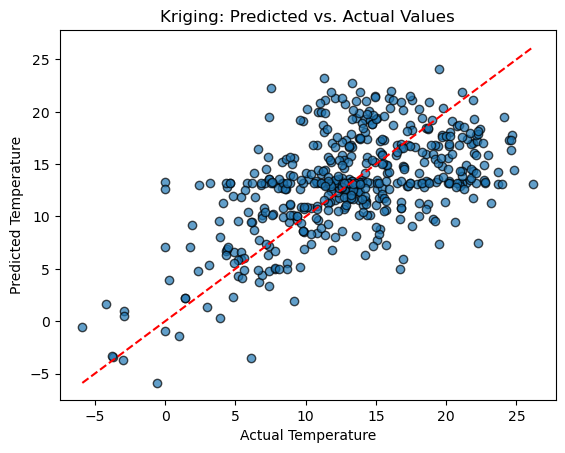

In [ ]:
plt.scatter(actual_values, predicted_values, alpha=0.7, edgecolors='k')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], 'r--')
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.title('Kriging: Predicted vs. Actual Values')
plt.show()


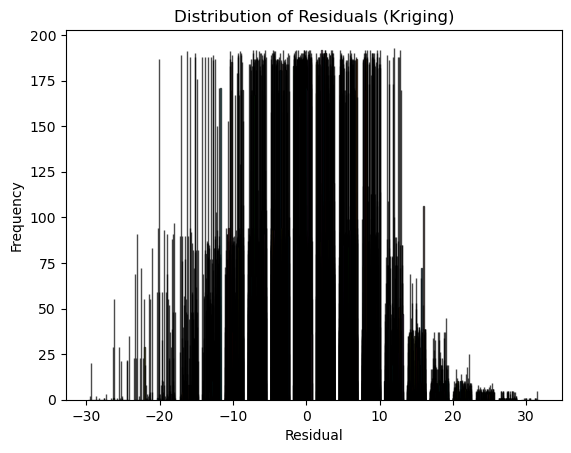

In [ ]:
residuals = np.array(actual_values) - np.array(predicted_values)
plt.hist(residuals, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Kriging)')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf


In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Evaluation Metrics:")
print(f"MSE: {mse_xgb}")
print(f"MAE: {mae_xgb}")
print(f"R² Score: {r2_xgb}")


In [ ]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

station_gdf.sort_values('timestamp', inplace=True)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

seq_length = 5
X_seq, y_seq = [], []

for i in range(len(X_scaled) - seq_length):
    X_seq.append(X_scaled[i:i + seq_length])
    y_seq.append(y.iloc[i + seq_length])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)


C:\Users\niran\AppData\Local\Temp\ipykernel_14468\2804738296.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_gdf.sort_values('timestamp', inplace=True)


In [ ]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(seq_length, X_train_seq.shape[2])),
    tf.keras.layers.Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, validation_data=(X_test_seq, y_test_seq))


c:\Users\niran\miniconda3\envs\era5_project\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
61007/61007 ━━━━━━━━━━━━━━━━━━━━ 151s 2ms/step - loss: 16.9465 - val_loss: 11.0827
Epoch 2/20
61007/61007 ━━━━━━━━━━━━━━━━━━━━ 147s 2ms/step - loss: 9.9926 - val_loss: 8.2611
Epoch 3/20
61007/61007 ━━━━━━━━━━━━━━━━━━━━ 147s 2ms/step - loss: 8.3884 - val_loss: 8.4094
Epoch 4/20
61007/61007 ━━━━━━━━━━━━━━━━━━━━ 146s 2ms/step - loss: 8.0998 - val_loss: 7.7678
Epoch 5/20
61007/61007 ━━━━━━━━━━━━━━━━━━━━ 148s 2ms/step - loss: 7.8853 - val_loss: 8.5547
Epoch 6/20
61007/61007 ━━━━━━━━━━━━━━━━━━━━ 171s 3ms/step - loss: 7.7995 - val_loss: 7.5170
Epoch 7/20
61007/61007 ━━━━━━━━━━━━━━━━━━━━ 162s 3ms/step - loss: 7.6881 - val_loss: 7.4536
Epoch 8/20
61007/61007 ━━━━━━━━━━━━━━━━━━━━ 122s 2ms/step - loss: 7.6167 - val_loss: 7.4073
Epoch 9/20
61007/61007 ━━━━━━━━━━━━━━━━━━━━ 123s 2ms/step - loss: 7.5480 - val_loss: 7.4353
Epoch 10/20
61007/61007 ━━━━━━━━━━━━━━━━━━━━ 161s 3ms/step - loss: 7.5235 - val_loss: 7.2996
Epoch 11/20
61007/61007 ━━━━━━━━━━━━━━━━━━━━ 124s 2ms/step - loss: 7.4809 - v

In [ ]:
y_pred_lstm = lstm_model.predict(X_test_seq)

mse_lstm = mean_squared_error(y_test_seq, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
r2_lstm = r2_score(y_test_seq, y_pred_lstm)

print("LSTM Evaluation Metrics:")
print(f"MSE: {mse_lstm}")
print(f"MAE: {mae_lstm}")
print(f"R² Score: {r2_lstm}")


15252/15252 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step
LSTM Evaluation Metrics:
MSE: 8.4338675015569
MAE: 2.2398957020502865
R² Score: 0.7231012403911432


In [ ]:
from catboost import CatBoostRegressor

catboost_model = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, random_state=42, verbose=0)

catboost_model.fit(X_train, y_train)

y_pred_catboost = catboost_model.predict(X_test)

mse_catboost = mean_squared_error(y_test, y_pred_catboost)
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
r2_catboost = r2_score(y_test, y_pred_catboost)

print("CatBoost Evaluation Metrics:")
print(f"MSE: {mse_catboost}")
print(f"MAE: {mae_catboost}")
print(f"R² Score: {r2_catboost}")


In [ ]:
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense


time_steps = 5
features = 6  

X_seq_conv = X_seq.reshape((X_seq.shape[0], time_steps, 1, 1, features))

X_train_conv, X_test_conv, y_train_conv, y_test_conv = train_test_split(X_seq_conv, y_seq, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense

conv_lstm_model = Sequential()
conv_lstm_model.add(ConvLSTM2D(filters=64, kernel_size=(1, 1), activation='relu', input_shape=(time_steps, 1, 1, features)))
conv_lstm_model.add(Flatten())
conv_lstm_model.add(Dense(1))

conv_lstm_model.compile(optimizer='adam', loss='mse')

conv_lstm_model.fit(X_train_conv, y_train_conv, epochs=5, batch_size=32, validation_data=(X_test_conv, y_test_conv))


c:\Users\niran\miniconda3\envs\era5_project\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
61007/61007 ━━━━━━━━━━━━━━━━━━━━ 302s 5ms/step - loss: 16.6001 - val_loss: 10.2800
Epoch 2/10
61007/61007 ━━━━━━━━━━━━━━━━━━━━ 309s 5ms/step - loss: 9.2427 - val_loss: 7.9048
Epoch 3/10
61007/61007 ━━━━━━━━━━━━━━━━━━━━ 285s 5ms/step - loss: 8.1261 - val_loss: 7.6748
Epoch 4/10
61007/61007 ━━━━━━━━━━━━━━━━━━━━ 287s 5ms/step - loss: 7.8581 - val_loss: 8.3876
Epoch 5/10
61007/61007 ━━━━━━━━━━━━━━━━━━━━ 307s 5ms/step - loss: 7.7365 - val_loss: 7.7839
Epoch 6/10
61007/61007 ━━━━━━━━━━━━━━━━━━━━ 306s 5ms/step - loss: 7.6188 - val_loss: 7.5691
Epoch 7/10
61007/61007 ━━━━━━━━━━━━━━━━━━━━ 304s 5ms/step - loss: 7.5296 - val_loss: 7.3237
Epoch 8/10
61007/61007 ━━━━━━━━━━━━━━━━━━━━ 301s 5ms/step - loss: 7.4656 - val_loss: 7.3268
Epoch 9/10
61007/61007 ━━━━━━━━━━━━━━━━━━━━ 298s 5ms/step - loss: 7.4462 - val_loss: 7.3253
Epoch 10/10
61007/61007 ━━━━━━━━━━━━━━━━━━━━ 300s 5ms/step - loss: 7.4031 - val_loss: 7.3143


In [ ]:
y_pred_convlstm = conv_lstm_model.predict(X_test_conv)

# Calculate evaluation metrics for ConvLSTM
mse_convlstm = mean_squared_error(y_test_conv, y_pred_convlstm)
mae_convlstm = mean_absolute_error(y_test_conv, y_pred_convlstm)
r2_convlstm = r2_score(y_test_conv, y_pred_convlstm)

print("ConvLSTM Evaluation Metrics:")
print(f"MSE: {mse_convlstm}")
print(f"MAE: {mae_convlstm}")
print(f"R² Score: {r2_convlstm}")


15252/15252 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step
ConvLSTM Evaluation Metrics:
MSE: 7.314304821292865
MAE: 2.116305130399408
R² Score: 0.7598584597110165


In [ ]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(ConvLSTM2D(filters=hp.Int('filters', min_value=32, max_value=128, step=32),
                         kernel_size=(1, 1),
                         activation='relu',
                         input_shape=(time_steps, 1, 1, features)))
    model.add(Flatten())
    model.add(Dense(1))

    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='conv_lstm_tuning',
    project_name='conv_lstm_temp_pred'
)

tuner.search(X_train_conv, y_train_conv, epochs=5, validation_data=(X_test_conv, y_test_conv), batch_size=32)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters:\nFilters: {best_hps.get('filters')}\nLearning Rate: {best_hps.get('learning_rate')}")


Reloading Tuner from conv_lstm_tuning\conv_lstm_temp_pred\tuner0.json
Best Hyperparameters:
Filters: 64
Learning Rate: 0.001


In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3, shuffle=True, random_state=42)

mse_scores = []
mae_scores = []
r2_scores = []

for train_index, val_index in kf.split(X_train_conv):
    X_train_fold, X_val_fold = X_train_conv[train_index], X_train_conv[val_index]
    y_train_fold, y_val_fold = y_train_conv[train_index], y_train_conv[val_index]

    model = Sequential()
    model.add(ConvLSTM2D(filters=best_hps.get('filters'), kernel_size=(1, 1), activation='relu', input_shape=(time_steps, 1, 1, features)))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=best_hps.get('learning_rate')), loss='mse')

    model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=32, verbose=0, validation_data=(X_val_fold, y_val_fold))

    y_val_pred = model.predict(X_val_fold)
    mse = mean_squared_error(y_val_fold, y_val_pred)
    mae = mean_absolute_error(y_val_fold, y_val_pred)
    r2 = r2_score(y_val_fold, y_val_pred)

    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

print(f"ConvLSTM Cross-Validation MSE Scores: {mse_scores}")
print(f"Mean Cross-Validation MSE: {np.mean(mse_scores)}")
print(f"Mean Cross-Validation MAE: {np.mean(mae_scores)}")
print(f"Mean Cross-Validation R²: {np.mean(r2_scores)}")


c:\Users\niran\miniconda3\envs\era5_project\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20336/20336 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step


c:\Users\niran\miniconda3\envs\era5_project\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20336/20336 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step


c:\Users\niran\miniconda3\envs\era5_project\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20336/20336 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step
ConvLSTM Cross-Validation MSE Scores: [7.839238995923292, 7.508413844059041, 7.914612218652499]
Mean Cross-Validation MSE: 7.754088352878277
Mean Cross-Validation MAE: 2.188487482424043
Mean Cross-Validation R²: 0.7444351331005349


In [ ]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten()
    
    non_zero_mask = y_true != 0
    y_true, y_pred = y_true[non_zero_mask], y_pred[non_zero_mask]
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_convlstm = mean_absolute_percentage_error(y_test_conv, y_pred_convlstm)
print(f"ConvLSTM Mean Absolute Percentage Error (MAPE): {mape_convlstm}%")


ConvLSTM Mean Absolute Percentage Error (MAPE): 25.429787170113897%


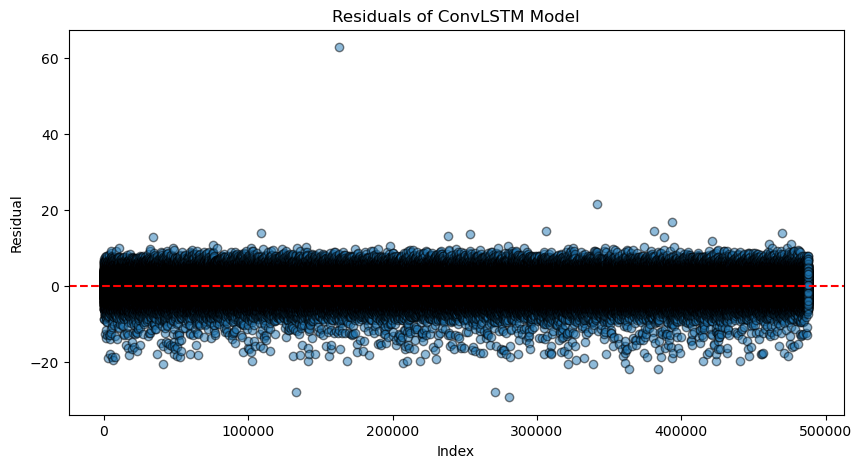

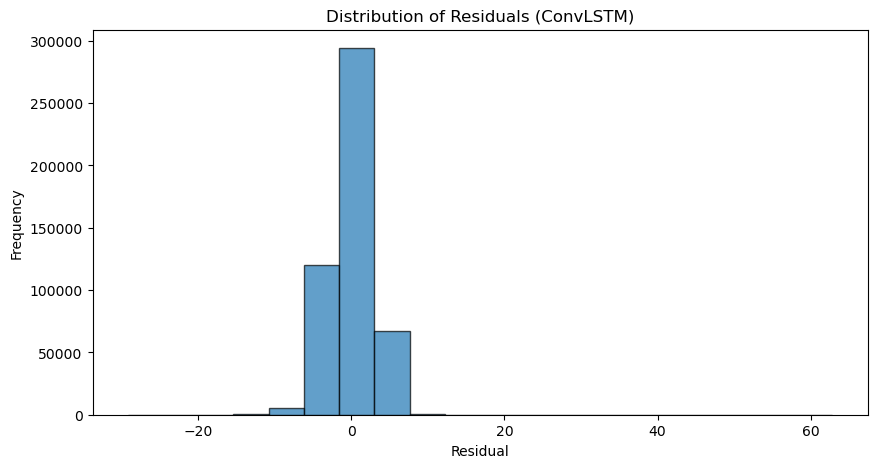

In [ ]:
residuals_convlstm = y_test_conv.flatten() - y_pred_convlstm.flatten()

plt.figure(figsize=(10, 5))
plt.scatter(range(len(residuals_convlstm)), residuals_convlstm, alpha=0.5, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Residuals of ConvLSTM Model')
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(residuals_convlstm, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (ConvLSTM)')
plt.show()


In [ ]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

time_steps = 5  
features = 6    
def build_model(hp):
    model = Sequential()
    
    filters = hp.Int('filters', min_value=32, max_value=128, step=32)
    
    kernel_height = hp.Choice('kernel_height', values=[1])
    kernel_width = hp.Choice('kernel_width', values=[1])
    
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    
    model.add(ConvLSTM2D(filters=filters,
                         kernel_size=(kernel_height, kernel_width),
                         activation='relu',
                         input_shape=(time_steps, 1, 1, features)))
    
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(1))

    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    directory='conv_lstm_tuning',
    project_name='conv_lstm_temp_pred',
    overwrite=True  # Allow overwriting previous trials
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

X_train_conv = X_train_conv.reshape(-1, time_steps, 1, 1, features)
X_test_conv = X_test_conv.reshape(-1, time_steps, 1, 1, features)

X_train_conv = X_train_conv.astype('float32')
y_train_conv = y_train_conv.astype('float32')
X_test_conv = X_test_conv.astype('float32')
y_test_conv = y_test_conv.astype('float32')

tuner.search(
    X_train_conv, y_train_conv,
    epochs=5,
    validation_data=(X_test_conv, y_test_conv),
    batch_size=32,  # You can modify this to tune batch size separately if needed
    callbacks=[early_stopping]
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters:\nFilters: {best_hps.get('filters')}\nKernel Height: {best_hps.get('kernel_height')}\nKernel Width: {best_hps.get('kernel_width')}\nDropout Rate: {best_hps.get('dropout_rate')}\nLearning Rate: {best_hps.get('learning_rate')}")


Trial 10 Complete [00h 32m 27s]
val_loss: 7.512688159942627

Best val_loss So Far: 7.512688159942627
Total elapsed time: 04h 22m 03s
Best Hyperparameters:
Filters: 96
Kernel Height: 1
Kernel Width: 1
Dropout Rate: 0.2
Learning Rate: 0.001


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:
y_pred = model.predict(X_test_conv)


15252/15252 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step


In [ ]:
mse = mean_squared_error(y_test_conv, y_pred)
mae = mean_absolute_error(y_test_conv, y_pred)
r2 = r2_score(y_test_conv, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")


Mean Squared Error (MSE): 7.9005584716796875
Mean Absolute Error (MAE): 2.2015697956085205
R² Score: 0.7406107187271118


In [ ]:
residuals = y_test_conv.flatten() - y_pred.flatten()


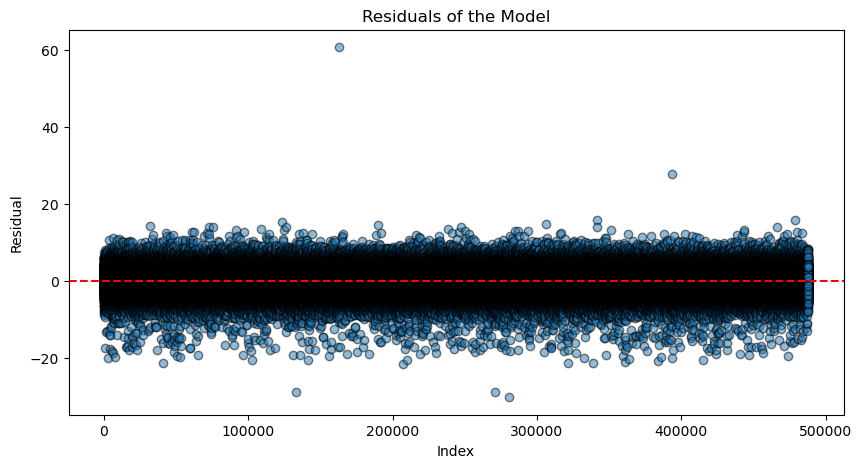

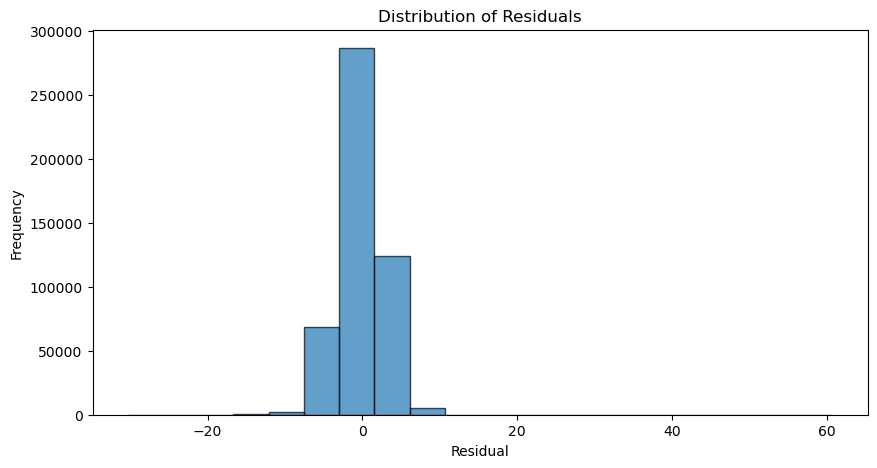

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(range(len(residuals)), residuals, alpha=0.5, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Residuals of the Model')
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()
